In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import matplotlib.gridspec as gridspec

from torch.nn import functional as F
from scipy.stats import multivariate_normal
from State_Space_Model import Stochastic_Lorenz96
from flow_models import RealNVP, Flow_based_Bayesian_Filter, MLP
from torch.utils.data import TensorDataset
from tqdm import tqdm, trange
from mpl_toolkits.axes_grid1 import make_axes_locatable
from metrics import (Calc_root_mean_square_error,
                     Calc_sample_covariance,
                     Calc_spread)

# torch.manual_seed(1226)
# np.random.seed(1226)
device = torch.device("cuda:0")

######################################
############ Model Parameters ########
######################################
T = 500
T_test = 500
r2 = 1
q2 = 0.01
obs_type = 'NL'
m = 50
n = m

if not os.path.exists('./Data'):
    os.mkdir('./Data')

N_train = 2000
N_test = 200
dataFolderName = './Data/'
dataFileName = 'Lorenz96_q2={:.3f}_r2={:.3f}_m={}_T={}_obs={}.npy'.format(q2, r2, m, T, obs_type)
data_filename = dataFolderName + dataFileName

In [5]:
######################################
############# Load Datasets ##########
######################################
if not os.path.exists('./models'):
    os.mkdir('./models')
    
model_path = './models/'+'FBF_'+ dataFileName[0:-4]
if not os.path.exists(model_path):
    os.mkdir(model_path)

print("Load prepared data...")
x_train, y_train, x_test, y_test = np.load(data_filename, allow_pickle=True)

print("x train size:", x_train.shape)
print("y train size:", y_train.shape)
print("x test size:", x_test.shape)
print("y test size:", y_test.shape)

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

batch_size_train = 64
batch_size_test = 64
train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size_train, 
                                           shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test[:, 0:T], y_test[:, 0:T]), batch_size=batch_size_test,
                                           shuffle=True, drop_last=True)

Load prepared data...
x train size: (2000, 500, 50)
y train size: (2000, 500, 50)
x test size: (200, 500, 50)
y test size: (200, 500, 50)


In [3]:
###################### Build FBF Model ######################
n_epochs = 5000
arch_params = {"Tx_units": 128, "Tx_layers": 8, "Ty_units": 128, "Ty_layers": 8, 
               "A_net_units": 128, "A_net_layers": 8, "B_net_units": 128, "B_net_layers": 8}

model = Flow_based_Bayesian_Filter(arch_params, m, n, train_loader, test_loader, device)
model.FBF_compile(n_epochs)

###################### Train FBF Model ######################
try:
    optimal_loss = float('inf')
    start_time = time.time()

    for epoch in range(n_epochs):
        model.train(epoch, device)
        model.test(epoch, device)

        if optimal_loss > model.loss_test[-1]:
            optimal_loss = model.loss_test[-1]
            model.save_model(model_path)
        model.scheduler.step()
        
except KeyboardInterrupt:
    pass
finally:
    print("==> Best test loss: %.6f" % (optimal_loss))
    print("Time elapsed:", time.time() - start_time)

==> Epoch: 0
Average train loss: 406.821875,	 loss state: 107.282319,	 loss obs: 299.539556
Average train loss: 377.585897,	 loss state: 79.160080,	 loss obs: 298.425822
==> Epoch: 1
Average train loss: 370.264688,	 loss state: 72.727753,	 loss obs: 297.536933
Average train loss: 358.338582,	 loss state: 62.585347,	 loss obs: 295.753235
==> Epoch: 2
Average train loss: 328.642304,	 loss state: 37.582308,	 loss obs: 291.059994
Average train loss: 306.261597,	 loss state: 21.503278,	 loss obs: 284.758321
==> Best test loss: 306.261597
Time elapsed: 19.42845869064331


In [6]:
##########################################
######## Load pre-trained Models  ######## 
##########################################
arch_params = {"Tx_units": 128, "Tx_layers": 8, "Ty_units": 128, "Ty_layers": 8, 
               "A_net_units": 128, "A_net_layers": 8, "B_net_units": 128, "B_net_layers": 8}
model = Flow_based_Bayesian_Filter(arch_params, m, n, train_loader, test_loader, device)
model.load_model(model_path, device)

In [7]:
# sample on a test case
idx_test = 25
ensemble_size = 500
measurement = y_test[idx_test, 0:T].to(device)
x_ensemble_sample = model.calc_ensemble(ensemble_size, measurement, T, device)
x_ensemble_sample = x_ensemble_sample.cpu().detach().numpy()

# evaluate
x_true_value = x_test[idx_test, 1:T]
x_spread = Calc_spread(x_ensemble_sample)

# RMSE
x_pred_value = x_ensemble_sample.mean(1)
x_rmse = Calc_root_mean_square_error(x_true_value, x_pred_value)

print("Metric for this test case:")
print("RMSE: ", x_rmse)
print("Spread: ", x_spread)

100%|███████████████████████████████| 499/499 [00:07<00:00, 66.41it/s]


Metric for this test case:
RMSE:  0.3046909065986449
Spread:  0.36980170581067284


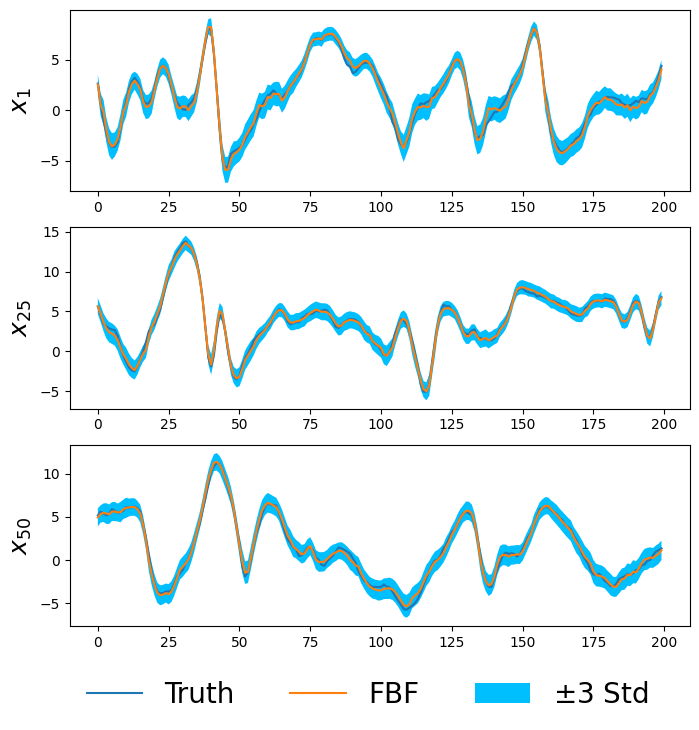

In [10]:
########################################################
############## Plot Confidence Interval ################
########################################################
def visualize_confidence_interval(T, true_state, x_ensemble_sample, x_cov):
    T_trunc = 200
    true_state = true_state[-T_trunc:]
    x1_mean = x_ensemble_sample[..., 0].mean(1)[-T_trunc:]
    x2_mean = x_ensemble_sample[..., 24].mean(1)[-T_trunc:]
    x3_mean = x_ensemble_sample[..., -1].mean(1)[-T_trunc:]

    x1_std = np.sqrt(x_cov[..., 0, 0])[-T_trunc:]
    x2_std = np.sqrt(x_cov[..., 24, 24])[-T_trunc:]
    x3_std = np.sqrt(x_cov[..., -1, -1])[-T_trunc:]
    x1_lb = x1_mean - 3 * x1_std
    x1_ub = x1_mean + 3 * x1_std
    x2_lb = x2_mean - 3 * x2_std
    x2_ub = x2_mean + 3 * x2_std
    x3_lb = x3_mean - 3 * x3_std
    x3_ub = x3_mean + 3 * x3_std
    
    plt.style.use('default')
    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_subplot(3, 1, 1)
    ax.plot(range(T_trunc), true_state[:, 0], label='Truth')
    ax.plot(range(T_trunc), x1_mean, label='FBF')
    ax.set_ylabel(r'$x_1$', fontsize=18)
    plt.fill_between(range(T_trunc), x1_lb, x1_ub, facecolor='deepskyblue', label=r'$\pm 3$' + ' Std')

    ax = fig.add_subplot(3, 1, 2)
    ax.plot(range(T_trunc), true_state[:, 24], label='Truth')
    ax.plot(range(T_trunc), x2_mean, label='FBF')
    ax.set_ylabel(r'$x_{25}$', fontsize=18)
    plt.fill_between(range(T_trunc), x2_lb, x2_ub, facecolor='deepskyblue', label=r'$\pm 3$' + ' Std')
    
    ax = fig.add_subplot(3, 1, 3)
    ax.plot(range(T_trunc), true_state[:, -1], label='Truth')
    ax.plot(range(T_trunc), x3_mean, label='FBF')
    ax.set_ylabel(r'$x_{50}$', fontsize=18)
    plt.fill_between(range(T_trunc), x3_lb, x3_ub, facecolor='deepskyblue', label=r'$\pm 3$' + ' Std')

    ax.legend(loc='upper center', bbox_to_anchor=(0.48, -0.165), ncol=3, frameon=False, fontsize=20)
    
x_cov = Calc_sample_covariance(x_ensemble_sample)
visualize_confidence_interval(T, x_true_value, x_ensemble_sample, x_cov)